# Best Classifier - An Analysis of ML Classification Algorithms

This project applies different ML algorithms for classification and then evaluates the accuracy of these models in predicting whether a loan applicant will pay off the loan or default on the money. 

The algorithms used are as follows:
<ol>
    <li>K Nearest Neighbors</li>
    <li>Decision Tree</li>
    <li>Support Vector Machine</li>
    <li>Logistic Regression</li>
</ol>

The general workflow will be as follows:
<ul>
    <li>Importing the training dataset</li>
    <li>Cleaning and pre-processing of the training dataset</li>
    <li>Feature selection from the training dataset</li>
    <li>Splitting the training dataset into a training subset and a testing subset</li>
    <li>Running each classification algorithm</li>
    <li>Evaluating accuracy of each algorithm by checking predictions against the true values in the testing subset</li>
    <li>Importing an unseen testing dataset</li>
    <li>Running each algorithm once again on the new testing dataset</li>
    <li>Tabulating the accuracies obtained from classifying unseen data</li>

In [1]:
#importing required libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [2]:
#downloading the dataset
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-06-26 07:59:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-06-26 07:59:19 (12.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

In [5]:
#converting the dates to datetime objects
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



In [6]:
#seeing how many of each class are in the dataset
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


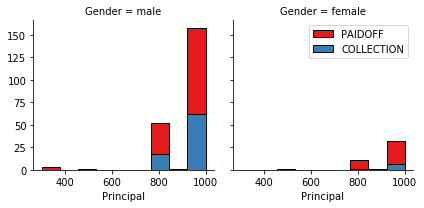

In [7]:
#plotting some columns for better data understanding
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

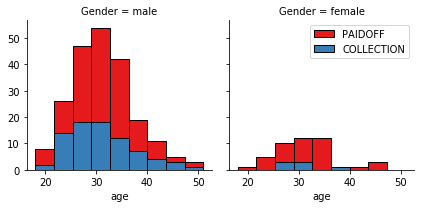

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

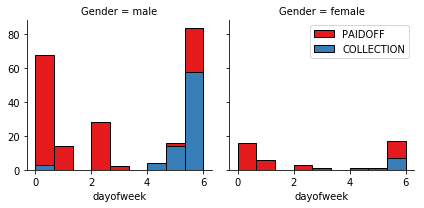

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off.

In [10]:
#using feature binarization to set a threshold value for days less than 4
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Converting categorical features to numerical values

Let's look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86% of female pay their loans while only 73% of males pay theirs.


Lets convert male to 0 and female to 1:


In [12]:
#converting males to 0 and females to 1
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One-Hot Encoding  

Let's look at education

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One-Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use One-Hot Encoding to convert categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Defining feature set X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


Defining labels set y:

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

This gives the data zero mean and unit variance.

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

## K Nearest Neighbors (KNN)


In [19]:
#split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [20]:
#training the model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#initializing 
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

#looping through different values of k to find the best one
for n in range(1, Ks):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat1 = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test,yhat1)
    std_acc[n-1] = np.std(yhat1==y_test)/np.sqrt(yhat1.shape[0])
mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

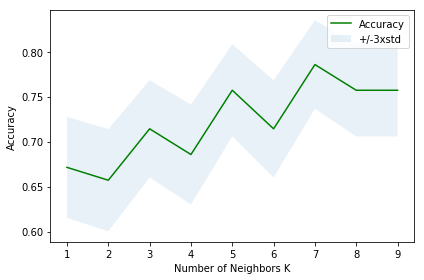

The best accuracy (Jaccard index) was  0.7857142857142857 with k =  7


In [21]:
#plotting the model to view accuracy for different values of k
plt.plot(range(1,Ks), mean_acc, 'g')
plt.fill_between(range(1,Ks), mean_acc-1*std_acc, mean_acc+1*std_acc, alpha=0.10)
plt.legend(('Accuracy', '+/-3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors K')
plt.tight_layout()
plt.show()
print("The best accuracy (Jaccard index) was ", mean_acc.max(), "with k = ", mean_acc.argmax()+1)


# Decision Tree

In [22]:
#training the model
from sklearn.tree import DecisionTreeClassifier
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)
loanTree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
loanTree.fit(X_train, y_train)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
#making predictions with the tree
predTree = loanTree.predict(X_test)
print("Prediction Tree's first 5 values:", predTree[0:5])
print("True Y test set's first 5 values:", y_test[0:5])

Prediction Tree's first 5 values: ['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
True Y test set's first 5 values: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [24]:
#evaluation of accuracy
from sklearn import metrics
print("Subset accuracy:", metrics.accuracy_score(y_test, predTree))

Subset accuracy: 0.6142857142857143


# Support Vector Machine

In [25]:
#training the model
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)
from sklearn import svm
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, y_train)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [26]:
#making a prediction using the SVM
yhat2 = clf.predict(X_test)
yhat2[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [27]:
#evaluation of accuracy

#F1-score
from sklearn.metrics import f1_score
print("F1-score:", f1_score(y_test, yhat2, average='weighted'))

#Jaccard Index
from sklearn.metrics import jaccard_similarity_score
print("Jaccard index:", jaccard_similarity_score(y_test, yhat2))

F1-score: 0.7275882012724117
Jaccard index: 0.7428571428571429


# Logistic Regression

In [28]:
#training the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
#making a prediction
yhat3 = LR.predict(X_test)
yhat3_probs = LR.predict_proba(X_test)
print("Y_hat (first 5):", yhat3[0:5])

Y_hat (first 5): ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [30]:
#evaluation of accuracy

#Jaccard index
print("Jaccard index:", jaccard_similarity_score(y_test, yhat3))

#LogLoss
from sklearn.metrics import log_loss
print("LogLoss:", log_loss(y_test, yhat3_probs))

Jaccard index: 0.6857142857142857
LogLoss: 0.5772287609479654


# Model Evaluation using Test set

Downloading and testing the new test set:

In [31]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-06-26 07:59:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-06-26 07:59:22 (193 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [32]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [33]:
#pre-processing the test set
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#convert categorical features to numerical values
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

#one-hot encoding
Feature1 = test_df[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df['education'])], axis=1)
Feature1.drop(['Master or Above'], axis = 1,inplace=True)
Feature1.head()

#feature selection
X1 = Feature1
y1 = test_df['loan_status'].values

#normalization of feature set
X1= preprocessing.StandardScaler().fit(X1).transform(X1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:23: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [34]:
#creating a dictionary to store the accuracy of each classifier's predictions
accuracies = {}

In [35]:
#KNN evaluation
#creating a new KNN model with the best k value (7)
new_neigh = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
knn_pred = new_neigh.predict(X1)
accuracies['KNN-jaccard_index']=jaccard_similarity_score(y1, knn_pred)
accuracies['KNN-f1-score']=f1_score(y1, knn_pred, average='weighted')

In [36]:
#Decision Tree evaluation
newPredTree = loanTree.predict(X1)
accuracies['DT-jaccard_index']=jaccard_similarity_score(y1, newPredTree)
accuracies['DT-f1-score']=f1_score(y1, newPredTree, average='weighted')

In [37]:
#SVM evaluation
SVMpred = clf.predict(X1)
accuracies['SVM-jaccard_index']=jaccard_similarity_score(y1, SVMpred)
accuracies['SVM-f1-score']=f1_score(y1, SVMpred, average='weighted')

In [38]:
#Logistic Regression evaluation
LRpred = LR.predict(X1)
LRpred_probs = LR.predict_proba(X1)
accuracies['LR-jaccard_index']=jaccard_similarity_score(y1, LRpred)
accuracies['LR-f1-score']=f1_score(y1, LRpred, average='weighted')
accuracies['LR-logLoss']=log_loss(y1, LRpred_probs)

In [39]:
#accuracies after using new test set
accuracies

{'KNN-jaccard_index': 0.6666666666666666,
 'KNN-f1-score': 0.6328400281888654,
 'DT-jaccard_index': 0.7222222222222222,
 'DT-f1-score': 0.7366818873668188,
 'SVM-jaccard_index': 0.7962962962962963,
 'SVM-f1-score': 0.7583503077293734,
 'LR-jaccard_index': 0.7407407407407407,
 'LR-f1-score': 0.6604267310789049,
 'LR-logLoss': 0.5672153379912981}

# Report
After performing classifications on predictions on the unseen test data, the accuracies obtained were as follows:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.6667  | 0.6328   | N/A     |
| Decision Tree      | 0.7222  | 0.7367   | N/A     |
| SVM                | 0.7963  | 0.7584   | N/A     |
| LogisticRegression | 0.7407  | 0.6604   | 0.5672  |

As can be seen from the table above, the Support Vector Machine performed the best with unseen data, even though KNN showed the best performance with seen data.